In [1]:
import numpy as np
import pandas as pd
import os
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from collections import OrderedDict

In [2]:
from platform import python_version
print(python_version())

3.6.6


### Create edgelist using events data

In [147]:
movies = pd.read_csv('../../data/metadata_events_table.tsv', sep = '\t')

In [148]:
movies.head()

,Wikipedia_id,Freebase_id,Name,Release_date,Revenue,Runtime,Languages,Countries,Genres,Events
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","['send', 'hold', 'find', 'learn', 'murder', 'f..."
1,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","['draw', 'learn', 'meet', 'fall', 'enter', 'fi..."
2,11250635,/m/02r52hc,The Mechanical Monsters,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...","['spot', 'struggle', 'demand', 'be', 'free', '..."
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...","['return', 'engage', 'return', 'reveal', 'thro..."
4,9633533,/m/02pml15,Vandanam,1989,NaN,168.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}","['stay', 'transform', 'accept', 'use', 'reveal..."


In [149]:
def filter_genre(cell):
    genre_list = ['Action']
    ftd_list = [item for item in eval(cell).values() if item in genre_list]
    if len(ftd_list) == 1:
        return True
    else:
        return False

In [150]:
s = movies.Genres.apply(lambda cell: filter_genre(cell))

In [151]:
selected = [str(item) for item in movies[s].Wikipedia_id.tolist()]

In [163]:
event_file = [item for item in os.listdir('../../data/protag_events_v2') if str(item.split('_')[0]) in selected]

In [153]:
len(event_file)

2242

In [154]:
events_all = []
cnt = 0
for name in event_file:
    movie_events = []
    with open(os.path.join('../../data/protag_events_nogen/', name), 'r') as f:
        lines = [line.strip() for line in f.readlines()]
        for line in lines:
            line = line.split(' ')
            movie_events.append(line[1].split('-')[0])
        events_all.append(movie_events)


In [164]:
events_all = []
cnt = 0
for name in event_file:
    movie_events = []
    with open(os.path.join('../../data/protag_events_v2/', name), 'r') as f:
        lines = [line.strip() for line in f.readlines()]
        for line in lines:
#             line = line.split(' ')
            movie_events.append(line.replace('EmptyParameter', ''))
        events_all.append(movie_events)


In [130]:
def build_edgelist(events_all=events_all, use_top_nodes=False, top_events=None ):
    edgelist = []
    if use_top_nodes == False:
        for movie_event in events_all:
            for i in range(len(movie_event)-1):
                 edgelist.append((movie_event[i], movie_event[i+1]))
    else:
        events_all_flt = []
        for item in events_all:
            events_all_flt.extend(item)
        c = Counter(events_all_flt)
        top_events = set([item[0] for item in c.most_common(top_events)])
        for movie_event in events_all:
            for i in range(len(movie_event)-1):
        #         only use the most frequent x events
                if movie_event[i] in top_events and movie_event[i+1] in top_events:
                    edgelist.append((movie_event[i], movie_event[i+1]))
    return edgelist

In [131]:
edgelist = build_edgelist(events_all)

In [132]:
def build_wtd_edgelist(edgelist, k=1):
    edgelist_wtd = []
    c = Counter(edgelist)
    for item in edgelist:
        if c[item] > k:
            edge = (item[0], item[1], c[item])
            edgelist_wtd.append(edge)
    return edgelist_wtd

In [133]:
edgelist_wtd = build_wtd_edgelist(edgelist)

In [134]:
Counter(edgelist).most_common(20)

[(('include', 'include'), 903),
 (('have', 'have'), 215),
 (('find', 'find'), 166),
 (('meet', 'meet'), 164),
 (('tell', 'tell'), 156),
 (('become', 'become'), 154),
 (('take', 'take'), 138),
 (('tell', 'go'), 135),
 (('go', 'find'), 115),
 (('leave', 'leave'), 114),
 (('go', 'go'), 109),
 (('give', 'give'), 109),
 (('go', 'see'), 101),
 (('tell', 'have'), 100),
 (('get', 'get'), 97),
 (('leave', 'go'), 94),
 (('go', 'tell'), 89),
 (('go', 'have'), 87),
 (('have', 'go'), 84),
 (('tell', 'leave'), 82)]

### Build networkX network

In [135]:
G = nx.DiGraph()

In [136]:
G.add_weighted_edges_from(edgelist_wtd)

In [137]:
G.number_of_nodes()

937

In [138]:
G.number_of_edges()

16255

In [139]:
for item in sorted(dict(G.degree()), key=dict(G.degree()).get, reverse=True)[0:5]:
    print(item, G.degree()[item])

have 647
find 634
go 616
tell 613
take 592


In [140]:
for item in sorted(dict(G.in_degree()), key=dict(G.in_degree()).get, reverse=True)[0:5]:
    print(item, G.in_degree()[item])

go 322
have 314
tell 313
find 308
take 294


In [141]:
for item in sorted(dict(G.out_degree()), key=dict(G.out_degree()).get, reverse=True)[0:5]:
    print(item, G.out_degree()[item])

have 333
find 326
tell 300
take 298
go 294


In [142]:
nx.write_gml(G, 'event_network_drama.gml')

In [143]:
btw_cent = nx.betweenness_centrality(G)

In [144]:
for item in sorted(btw_cent, key=dict(btw_cent).get, reverse=True)[0:20]:
    print(item, btw_cent[item])

have 0.08146170661072556
find 0.07732670129222598
go 0.073019320440998
tell 0.06762845614754481
take 0.056621721654834575
try 0.036581019728065205
leave 0.03592243539694113
get 0.03164188049837022
meet 0.03151306861263236
see 0.03028958541627167
become 0.028866682060788098
decide 0.021804765243609907
kill 0.02093186618483226
begin 0.019841772930641457
return 0.017743919483735084
make 0.01731333188574857
give 0.016658785324424406
ask 0.014677596855045829
refuse 0.014293185205923882
come 0.012720937394677162


### Backbone extraction

In [217]:
from backbone import disparity_filter, disparity_filter_alpha_cut

In [218]:
G_c = disparity_filter(G)

In [219]:
G_c.number_of_nodes()

2026

In [223]:
C = disparity_filter_alpha_cut(G_c,weight='weight', alpha_t = 0.3)

In [224]:
C.number_of_edges()

7488

In [225]:
C.number_of_nodes()

908

In [226]:
nx.write_gml(C, 'event_network_backbone_nogen.gml')

In [227]:
nx.__version__

'2.2'

### Event transitions

In [73]:
df = pd.DataFrame.from_records(edgelist_wtd, columns = ['src', 'des', 'weight'])

In [74]:
df.head(2)

,src,des,weight
0,send,find,14
1,set,find,12


In [75]:
# Compute Size of Each event as source (S_i out)
s_src = df.groupby('src', as_index=False).agg({'weight': np.sum})
s_src.columns = ['src_event', 'size']

In [76]:
s_src.head(2)

,src_event,size
0,accept,160
1,agree,794


In [77]:
# Compute Size of Each event as destination (S_i in)
s_des = df.groupby('des', as_index=False).agg({'weight': np.sum})
s_des.columns = ['des_event', 'size']

In [78]:
s_des.head(2)

,des_event,size
0,accept,118
1,agree,509


In [79]:
expected = pd.merge(df, s_src, left_on='src', right_on = 'src_event')

In [80]:
expected.head(2)

,src,des,weight,src_event,size
0,send,find,14,send,866
1,send,realize,2,send,866


In [81]:
expected = pd.merge(expected, s_des, left_on='des', right_on='des_event', suffixes=['_src', '_des'])

In [82]:
len(expected)

14736

In [83]:
expected['exp'] = expected['size_src']*expected['size_des']/sum(expected['size_des']) # Sum of all in weights
expected['normed_weight'] = expected['weight']/expected['exp'] # Normalized = actual weight/expected weight
expected = expected[['src', 'des', 'normed_weight']]

In [84]:
expected = expected.drop_duplicates()

In [85]:
expected.head(2)

,src,des,normed_weight
0,send,find,134.843062
14,set,find,235.510773


In [86]:
len(expected)

3290

In [87]:
df = expected

### Hierarchical clustering

In [88]:
df = df.pivot(index="src", columns="des", values='normed_weight')
df.fillna(1.0, inplace=True)
df = np.log(df)

In [89]:
df.head()

des,accept,agree,appear,arrest,arrive,ask,attack,attempt,be,beat,...,track,travel,try,turn,use,visit,walk,want,win,work
src,,,,,,,,,,,,,,,,,,,,,
accept,0.0,0.000000,0.000000,0.000000,0.000000,7.278957,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,7.536945,0.0,0.0,0.000000,0.0,0.000000
agree,0.0,7.151212,0.000000,0.000000,5.829063,0.000000,7.584567,6.866728,6.442954,0.0,...,0.0,0.0,5.736829,0.0,6.340500,0.0,0.0,6.496618,0.0,8.563378
appear,0.0,0.000000,10.540348,0.000000,7.891026,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,7.393326,0.0,7.996998,0.0,0.0,0.000000,0.0,0.000000
arrest,0.0,8.099820,0.000000,9.464734,7.183137,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,7.601728,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
arrive,0.0,0.000000,0.000000,7.262104,6.685255,5.521638,6.736011,6.018171,5.594397,0.0,...,0.0,0.0,5.735570,0.0,5.086478,0.0,0.0,0.000000,0.0,0.000000


In [90]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import seaborn as sns


In [91]:

method = 'average'
metric = 'euclidean'
Z = hierarchy.linkage(df, method=method, metric=metric)
# c, coph_dists = hierarchy.cophenet(Z, pdist(df))
# part = hierarchy.fclusterdata(Z,1.5)

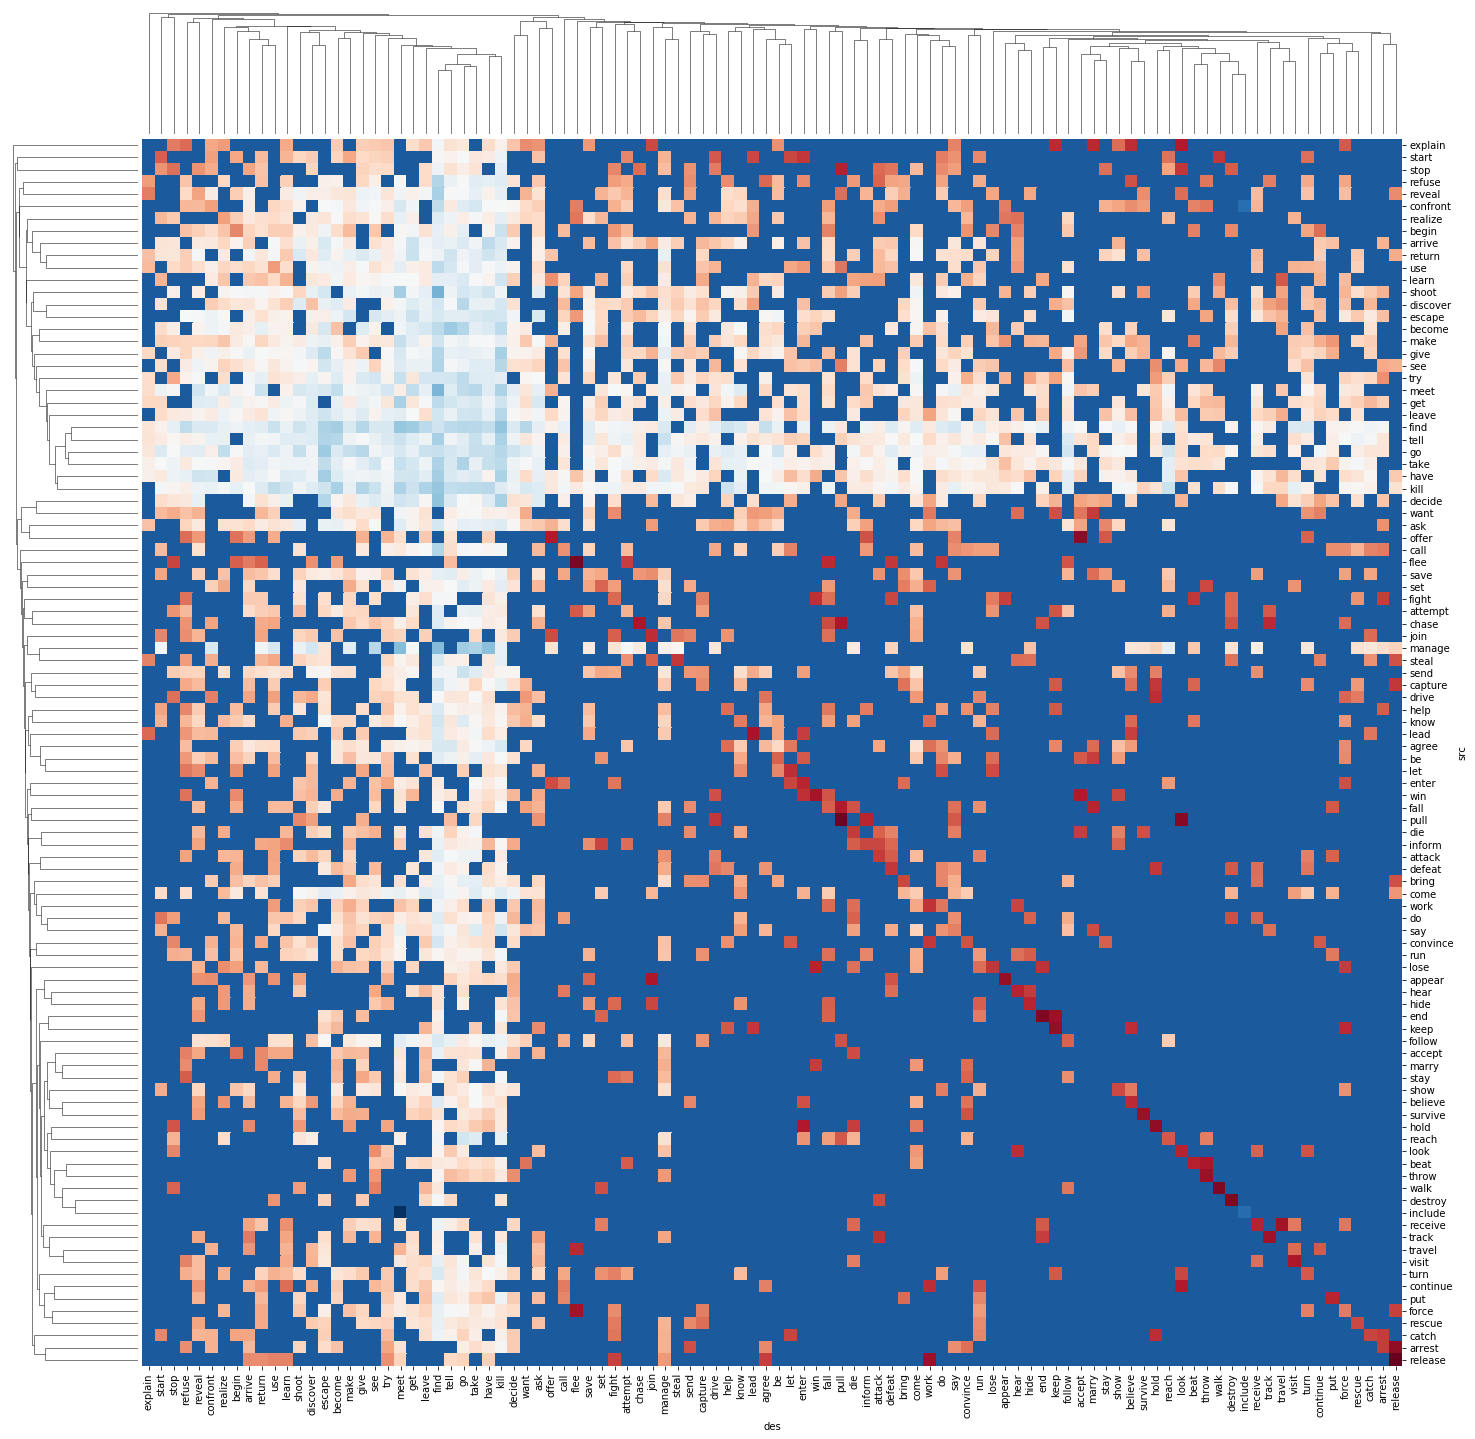

In [92]:
cm = sns.clustermap(df,figsize=(25, 25),row_linkage=Z, col_linkage=Z, cmap = "RdBu_r")#, xticklabels = False, yticklabels = False)
cm.cax.set_visible(False)

# plt.savefig('cluster_top_events_nogen.pdf', format='pdf')